In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/00000-20230303T173004Z-001.zip -d /content 

Archive:  /content/drive/MyDrive/00000-20230303T173004Z-001.zip
  inflating: /content/00000/00972.png  
  inflating: /content/00000/00979.png  
  inflating: /content/00000/00968.png  
  inflating: /content/00000/00977.png  
  inflating: /content/00000/00978.png  
  inflating: /content/00000/00999.png  
  inflating: /content/00000/00969.png  
  inflating: /content/00000/00985.png  
  inflating: /content/00000/00990.png  
  inflating: /content/00000/00997.png  
  inflating: /content/00000/00984.png  
  inflating: /content/00000/00993.png  
  inflating: /content/00000/00995.png  
  inflating: /content/00000/00980.png  
  inflating: /content/00000/00992.png  
  inflating: /content/00000/00998.png  
  inflating: /content/00000/00982.png  
  inflating: /content/00000/00983.png  
  inflating: /content/00000/00989.png  
  inflating: /content/00000/00973.png  
  inflating: /content/00000/00981.png  
  inflating: /content/00000/00971.png  
  inflating: /content/00000/00970.png  
  inflating: /co

In [ ]:
import os
import random
import shutil
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, Flatten
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

# Set the dimensions of the images
img_width, img_height = 224, 224

# Set the number of classes in your dataset
num_classes = 1

# Set the path of the FFHQ dataset folder
dataset_path = '/content/00000'

# Get a list of all the image filenames in the dataset folder
image_list = os.listdir(dataset_path)

# Shuffle the list of image filenames
random.shuffle(image_list)

# Set the percentage of images to use for validation
val_split = 0.2

# Calculate the number of images to use for validation
num_val = int(len(image_list) * val_split)

# Set the directory paths for your training and validation data
train_dir = '/content/train/training'
val_dir = '/content/validation/validating'

# Create the training and validation directories if they don't exist
if not os.path.exists(train_dir):
    os.makedirs(train_dir)

if not os.path.exists(val_dir):
    os.makedirs(val_dir)

# Move the first num_val images to the validation directory
for image_filename in image_list[:num_val]:
    source_path = os.path.join(dataset_path, image_filename)
    dest_path = os.path.join(val_dir, image_filename)
    shutil.move(source_path, dest_path)

# Move the remaining images to the training directory
for image_filename in image_list[num_val:]:
    source_path = os.path.join(dataset_path, image_filename)
    dest_path = os.path.join(train_dir, image_filename)
    shutil.move(source_path, dest_path)


In [ ]:
from keras.preprocessing.image import ImageDataGenerator

# Create an instance of the ImageDataGenerator for the training data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Create an instance of the ImageDataGenerator for the validation data
val_datagen = ImageDataGenerator(rescale=1./255)

# Create the generators for the training and validation data
train_generator = train_datagen.flow_from_directory('/content/train',target_size=(img_width, img_height),batch_size=4,class_mode='binary')

val_generator = val_datagen.flow_from_directory('/content/validation',target_size=(img_width, img_height),batch_size=4,class_mode='binary')


Found 951 images belonging to 1 classes.
Found 351 images belonging to 1 classes.


In [ ]:
# Load the pre-trained VGG16 model
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

# Freeze the pre-trained layers
for layer in vgg16.layers:
    layer.trainable = False

# Add new top layers for your specific task
x = Flatten()(vgg16.output)
x = Dense(128, activation='relu')(x)
x = Dense(num_classes, activation='sigmoid')(x)

# Create the new model
model = Model(inputs=vgg16.input, outputs=x)

# Compile the model
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=1e-5), metrics=['accuracy'])


In [ ]:
print(model.summary())

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
# Fit the model on the training data
model.fit(train_generator, steps_per_epoch=train_generator.samples // 4, epochs=10, validation_data=val_generator, validation_steps=val_generator.samples // 4)

Epoch 1/10
237/237 [==============================] - 939s 4s/step - loss: 0.0186 - accuracy: 1.0000 - val_loss: 2.7545e-04 - val_accuracy: 1.0000
Epoch 2/10
237/237 [==============================] - 897s 4s/step - loss: 2.0525e-04 - accuracy: 1.0000 - val_loss: 5.0869e-05 - val_accuracy: 1.0000
Epoch 3/10
237/237 [==============================] - 923s 4s/step - loss: 3.9853e-05 - accuracy: 1.0000 - val_loss: 1.4327e-05 - val_accuracy: 1.0000
Epoch 4/10
237/237 [==============================] - 926s 4s/step - loss: 1.6329e-05 - accuracy: 1.0000 - val_loss: 7.6539e-06 - val_accuracy: 1.0000
Epoch 5/10
237/237 [==============================] - 917s 4s/step - loss: 9.8256e-06 - accuracy: 1.0000 - val_loss: 4.8217e-06 - val_accuracy: 1.0000
Epoch 6/10
237/237 [==============================] - 919s 4s/step - loss: 6.5880e-06 - accuracy: 1.0000 - val_loss: 3.3115e-06 - val_accuracy: 1.0000
Epoch 7/10
237/237 [==============================] - 928s 4s/step - loss: 4.4963e-06 - accuracy: 

In [ ]:
# Evaluate the model on the test set
val_loss, val_accuracy = model.evaluate(val_generator)

# Print the test accuracy
print('Test accuracy:', val_accuracy, 'Test loss:', val_loss)


88/88 [==============================] - 255s 3s/step - loss: 1.1276e-06 - accuracy: 1.0000
Test accuracy: 1.0 Test loss: 1.127608015849546e-06


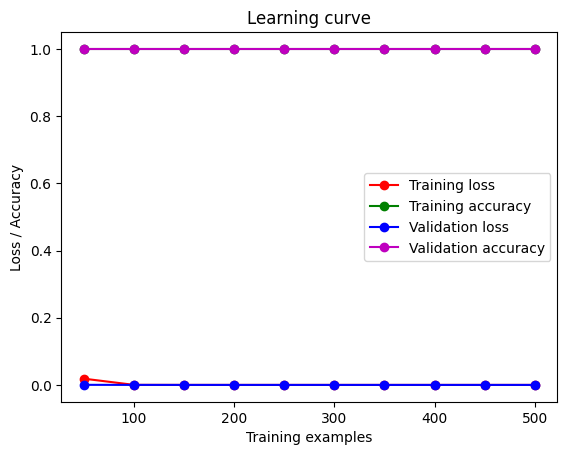

In [ ]:
import matplotlib.pyplot as plt

# Define the sizes of the training sets you want to use
train_sizes = [50, 100, 150, 200, 250, 300, 350,400,450,500]

# Define the corresponding loss and accuracy values
train_losses = [0.0186, 2.0525e-04, 3.9853e-05, 1.6329e-05, 9.8256e-06, 6.5880e-06, 4.4963e-06, 3.4714e-06, 2.6599e-06, 2.2143e-06]
train_accs = [1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,]
val_losses = [ 2.7545e-04, 5.0869e-05, 1.4327e-05, 7.6539e-06, 4.8217e-06, 3.3115e-06, 2.4179e-06, 1.8544e-06, 1.4407e-06, 1.1411e-06]
val_accs = [1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,]

# Plot the learning curve
plt.plot(train_sizes, train_losses, 'o-', color='r', label='Training loss')
plt.plot(train_sizes, train_accs, 'o-', color='g', label='Training accuracy')
plt.plot(train_sizes, val_losses, 'o-', color='b', label='Validation loss')
plt.plot(train_sizes, val_accs, 'o-', color='m', label='Validation accuracy')
plt.title('Learning curve')
plt.xlabel('Training examples')
plt.ylabel('Loss / Accuracy')
plt.legend(loc='best')
plt.show()
